# Прогнозирование стоимости автомобиля по характеристикам

## Задача - создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. 

### Описание признаков
ляллялялял

## Import

In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
from pandas import Series
import numpy as np
from numpy import mean
import json

from datetime import datetime, date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics.cluster import completeness_score, v_measure_score

from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

from scipy.stats import randint
import statsmodels.api as sm

from imblearn.pipeline import Pipeline

from math import log as log
import os

from itertools import combinations
from scipy.stats import ttest_ind

import re

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [5]:
RANDOM_SEED = 42

## Helpers

In [6]:
# Класс для обработки признака времени владения автомобилем.

class OwnershipPeriod():
    def __init__(self):
        self.pattern = re.compile('((\d+) (года|год|лет)){0,1}( и ){0,1}((\d+) (месяц)){0,1}')
        
    def get_months_from_ownership_period(self, x):
        '''Функция для подсчета кол-ва месяцев владения автомобилем, осуществляется через 
        преобразование кол-ва лет и месяцев в кол-во месяцев.'''
        search_res = self.pattern.search(str(x))

        years = 0
        months = 0

        if search_res.group(2):
            years = int(search_res.group(2))
        if search_res.group(6):
            months = int(search_res.group(6))

        return years*12 + months

In [7]:
def profile_report(df):
    '''Функция для вызова профайл-отчета о датафрейме'''
    
    if df is None:
        raise TypeError(nameof(df))

    profile = df.profile_report(
        title='Car Price prediction',
        progress_bar=False,
        correlations={
            'pearson': {'calculate': True},
            'spearman': {'calculate': True},
            'kendall': {'calculate': True},
            'phi_k': {'calculate': True},
            'cramers': {'calculate': True},
        },
        interactions={
            'continuous': True,
            'targets': []
        },
        missing_diagrams={
            'heatmap': True,
            'dendrogram': True,
            'matrix': True
        },
        vars={
            'cat': {'n_obs': 10}
        }
    )

    return profile

In [8]:
def asfloat(x, zero_if_none=False):
    '''Функция для перевода значения в float.'''
    if x is None or x == '':
        if zero_if_none:
            return 0
        else:
            return None
    else:
        return float(x)    

In [9]:
def asdict(x):
    '''Функция для замены значений в словаре.'''
    if type(x) != str:
        return None
    
    return eval(x.replace('true', 'True').replace('false', 'False'))

In [10]:
def labeling(col):
    '''Функция для кодирования признаков.'''
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [11]:
def get_log(df, col):
    '''Функция для логарифмирования признака'''
    
    return df[col].apply(lambda x: np.log(x + 1))

In [12]:
# Класс для исследования числовых признаков
class NumericInspector():
    def __init__(self, df):
        self.df = df

    def _prepare_series(self, column, log):
        return self.df[column] if log == False else get_log(self.df, column)

    def _show_plots(self, df_series, title, size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig = sm.qqplot(df_series, fit=True, line='45', ax=ax1)

        fig.suptitle(title, fontsize=20)

        ax2.hist(df_series, bins=20, histtype='bar', align='mid', rwidth=0.8)

        ax3.boxplot(df_series, vert=False)

        ax1.set_title('QQ-plot')
        ax2.set_title('Histogram')
        ax3.set_title('Boxplot')
        
        plt.show()

    def _boundaries(self, df_series):
        q1 = df_series.quantile(q=0.25, interpolation="midpoint")
        q3 = df_series.quantile(q=0.75, interpolation="midpoint")
        IQR = q3 - q1

        return q1 - 1.5*IQR, q3 + 1.5*IQR, q1, q3, IQR

    def _outliers(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)

        return len(df_series[df_series < minb]) + len(df_series[df_series > maxb])

    def _display_result_info(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)
        
        display(HTML(
            f'''
                <div style="text-align: center; margin-bottom: 20px;"> 
                    --- <span style="font-weight: bold;">q1: </span>
                    {np.round(q1, 2)},
                    <span style="font-weight: bold;">q3: </span>
                    {np.round(q3, 2)},
                    <span style="font-weight: bold;">IQR: </span>
                    {np.round(IQR, 2)},
                    <span style="font-weight: bold;">Boundaries: </span>
                    {np.round((minb, maxb), 2)}, 
                    <span style="font-weight: bold;">Outliers: </span>
                    {self._outliers(df_series)} --- 
                </div>
            '''))

    def inspect(self, column, size=5, with_log=True, title=None, title_for_log=None):
        # дефолтное отображение
        title_wl = title if title is not None else f"Inspection for '{column}' without 'log'"
        df_series = self._prepare_series(column, log=False)
        self._show_plots(df_series, title_wl, size)
        self._display_result_info(df_series)

        if with_log:
            # с логарифмированием
            title_fl = title_for_log if title_for_log is not None else f"Inspection for '{column}' with 'log'"
            try:
                df_series = self._prepare_series(column, log=True)
                self._show_plots(df_series, title_fl, size)
                self._display_result_info(df_series)
            except:
                plt.close()
                display(HTML(
                    f'''
                    <div style="text-align: center; margin-bottom: 22px;">
                        <span style="font-size: 20px; font-weight: bold;">Логарифмирование признака не удалось! :( </span>
                    </div>
                    '''))

        display(HTML('<hr style="width:90%; height:2px; border-width:0; color:gray; background-color:gray; margin-bottom: 30px;">'))

In [13]:
def get_stat_dif(column, data):
    '''Функция для нахождения статистической разницы для бинарных и категориальных признаков'''
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'price'],
                     data.loc[data.loc[:, column] == comb[1], 'price']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [14]:
def mape(y_true, y_pred):
    '''Функция для определения метрики'''
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Data

В рамках задания были предоставлены тестовые данные. Для получения обучающей выборки был произведен парсинг данных с сайта auto.ru. В версии ноутбука на github представлен код для парсинга. В рамках ноутбука на Kaggle загружается готовый датасет без указания кода для парсинга.

In [15]:
train = pd.read_csv('parsed_data.csv')
test = pd.read_csv('test.csv')

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52055 entries, 0 to 52054
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              52055 non-null  object 
 1   brand                 52055 non-null  object 
 2   car_url               52055 non-null  object 
 3   color                 52055 non-null  object 
 4   complectation_dict    10058 non-null  object 
 5   description           50321 non-null  object 
 6   engineDisplacement    52055 non-null  object 
 7   enginePower           52055 non-null  object 
 8   equipment_dict        52055 non-null  object 
 9   fuelType              52055 non-null  object 
 10  image                 0 non-null      float64
 11  mileage               52055 non-null  int64  
 12  modelDate             52055 non-null  int64  
 13  model_info            52055 non-null  object 
 14  model_name            52055 non-null  object 
 15  name               

In [17]:
train.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      41997
description              1734
engineDisplacement          0
enginePower                 0
equipment_dict              0
fuelType                    0
image                   52055
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                35436
ПТС                         2
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
price                       0
dtype: int

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [19]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

## Prepping data

Для корректной работы над данными и построения модели, необходимо провести первоначальную обработку имеющихся данных, чтобы наблюдения в тестовой и обучающей выборке были отражены одинаковым образом.

Посмотрим, есть ли у нас дубликаты в датасетах.

In [20]:
train['sell_id'].duplicated().sum()

0

In [21]:
test['sell_id'].duplicated().sum()

0

Объединим датасеты для дальнейшей обработки.

In [22]:
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

Проверим на дубликаты. Нет ли у нас в обучающей выборке наблюдений из тестовой, - иначе модель может работать не корректно.

In [23]:
data['sell_id'].duplicated(keep=False).sum()

3544

In [24]:
data[data.sell_id.duplicated(keep=False)].head(6)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,sample,price
128,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,Состояние нового авто. (цена в автосалоне от 1...,1.4 LTR,150 N12,"{""engine-proof"":true,""glonass"":true,""asr"":true...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,13000,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 MT (150 л.с.),5,1603226771,RUB,2020,1101109897,"{""id"":""20898379"",""displacement"":1395,""engine_t...",LIFTBACK MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,1 месяц,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
156,внедорожник 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/kodiaq/11...,чёрный,"{""id"":""21404914"",""name"":""Hockey Edition"",""avai...","Новый автомобиль, приобретался в Автосалоне Fa...",2.0 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,138,2016,"{""code"":""KODIAQ"",""name"":""Kodiaq"",""ru_name"":""Ко...",KODIAQ,2.0d AMT (150 л.с.) 4WD,5,1603226880,RUB,2020,1101313442,"{""id"":""20839377"",""displacement"":1968,""engine_t...",ALLROAD_5_DOORS ROBOT 2.0,роботизированная,EUROPEAN,1 владелец,4 месяца,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,NaN
226,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,бежевый,NaN,Продажа а/м осуществляется ОФИЦИАЛЬНЫМ ДИЛЕРОМ...,1.4 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,8045,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 AMT (150 л.с.),5,1603227152,RUB,2019,1100210074,"{""id"":""20898391"",""displacement"":1395,""engine_t...",WAGON_5_DOORS ROBOT 1.4,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
405,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серебристый,NaN,Продаю свою машину. Куплена новой в Минске. По...,1.8 LTR,160 N12,"{""cruise-control"":true,""esp"":true,""airbag-driv...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,249197,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,1.8 MT (160 л.с.) 4WD,5,1603227841,RUB,2013,1101303554,"{""id"":""20767690"",""displacement"":1798,""engine_t...",LIFTBACK MECHANICAL 1.8,механическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,NaN
433,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"{""id"":""20803791"",""name"":""Ambition"",""available_...",Продаю автомобиль (производство Чехия) по прич...,1.4 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,138000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 MT (150 л.с.),5,1603227943,RUB,2016,1101299678,"{""id"":""20642741"",""displacement"":1395,""engine_t...",WAGON_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,1 год и 2 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
537,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia_r...,синий,NaN,"Продаю свой автомобиль , в отличном состоянии ...",2.0 LTR,200 N12,"{""cruise-control"":true,""engine-proof"":true,""as...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,154000,2008,"{""code"":""OCTAVIA_RS"",""name"":""Octavia RS"",""ru_n...",OCTAVIA_RS,2.0 AMT (200 л.с.),5,1603228333,RUB,2012,1101186075,"{""id"":""5009158"",""displacement"":1984,""engine_ty...",LIFTBACK ROBOT 2.0,роботизированная,EUROPEAN,2 владельца,1 год и 1 месяц,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN


Такие наблюдения у нас есть. Удалим дубликаты пришедшие из обучающей выборки.

In [25]:
data = data.drop_duplicates(subset=['sell_id'], keep='first')

In [26]:
# Переимунуем колонки
data.rename(columns={
    'Владельцы': 'owners_number', 
    'Владение': 'ownership_period',
    'ПТС': 'pts', 
    'Привод': 'gear_type',
    'Руль': 'steering_wheel', 
    'Состояние': 'state', 
    'Таможня': 'custom_cleared'
}, inplace=True)

In [27]:
# Преобразуем значения в колонке steering_wheel
data['steering_wheel'] = data['steering_wheel'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

In [28]:
# Преобразуем значения в колонке pts
data['pts'] = data['pts'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

In [29]:
# Преобразуем значения в колонке bodyType
data['bodyType'] = data['bodyType'].apply(lambda x: x.split(' ')[0])

In [30]:
# Преобразуем значения в колонке engineDisplacement
# заменим пустые значения на 0, так как, судя по данным, они все относятся к электрокарам
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: asfloat(x[:-4], zero_if_none=True)).astype('float32')

In [31]:
# Преобразуем значения в колонке enginePower
data['enginePower'] = data['enginePower'].apply(lambda x: int(x[:-4])).astype('int32')

In [32]:
# Преобразуем значения в колонке owners_number
data['owners_number'] = data['owners_number'].apply(lambda x: int(x[0])).astype('int32')

In [33]:
# Преобразуем значения в колонке ownership_period - переведем все в кол-во месяцев
ownership_processor = OwnershipPeriod()

data['ownership_period'] = data['ownership_period'].apply(ownership_processor.get_months_from_ownership_period).astype('int32')

Далее преобразуем строковые величины в виде словарей в словари. Далее, возможно, возьмем оттуда информацию для улучшения точности модели. Из признака super_gen сразу возьмем значения расхода топлива и разгона.

In [34]:
# super_gen
data['super_gen'] = data['super_gen'].apply(lambda x: eval(x))

data['fuel_rate'] = data['super_gen'].apply(lambda x: x['fuel_rate'] if 'fuel_rate' in x.keys() else 0)
data['acceleration'] = data['super_gen'].apply(lambda x: x['acceleration'] if 'acceleration' in x.keys() else 0)

In [35]:
# equipment_dict
data['equipment_dict'] = data['equipment_dict'].apply(asdict)

In [36]:
# complectation_dict
data['complectation_dict'] = data['complectation_dict'].apply(asdict)

Удалим признаки, которые не несут для нас необходимой информации или дублируют то, что у нас уже представлено в других признаках.

In [37]:
data.drop(columns=[
    'name', 
    'model_info', 
    'image', 
    'vehicleConfiguration', 
    'car_url', 
    'parsing_unixtime',
    'priceCurrency', 
    'super_gen', 
    'state', 
    'custom_cleared'
], inplace=True)

In [38]:
# Подготовим данные для осмотра в HTML формате, ссылка на данные будет ниже

# data_profile = profile_report(data)
# data_profile.to_file('output.html')

## Data Inspection

In [39]:
# По желанию, профайл можно посмотреть внутри ноутбука.

# pandas_profiling.ProfileReport(data)

#### Ссылка на профайл **[the dataset profile report](./output.html)**.

### На основании профайлинга можем видеть следующее:

1. В датасете представлено **25 признаков** (sample мы не учитываем, так как это искусственно созданный признак для последующего удобства при разделении данных на тестовую и обучающую выборки.
2. В объединенных данных представлено **84969 наблюдений.**
3. Признак **bodyType / brand / color** содержат много уникальных значений, без пропусков. Далее закодируем данные признаки с помощью label encoding. 
4. Признак **словаря комплектаций** содержит очень много пустых значений. Даже если мы вытащим оттуда какой-то из ключей, более половины датафрейма по этому ключу будут нулевыми. Поэтому, скорее всего, далее, этот признак будет удален.
5. Признак **description.** Данный признак далее будет удален. Возможно, будет проведена обработка признака (векторизация или создание бинарных колонок при наличии того или иного слова/выражения, которые могут быть полезны для модели).
6. Признак **объема двигателя** - имеет числовую природу. Есть нулевые значения, относящиеся к электрокарам. Попробуем создать отдельный признак принадлежности автомобиля к электрической. Распределение смещенное, попробуем логарифмирование. Пропусков нет. Также попробуем создать признак объема двигателя категориальный.
7. Признак **мощности двигателя / пробега.** Распределение, в принципе, нормальное, немного смещено, попробуем логарифмирование. Пропусков нет. Также попробуем отобразить признаки мощности / пробега двигателя в качестве категориальных.
8. Признак **equipment_dict.** Более 10% значений пропущено. Внутри самого словаря также есть большая разница в ключах. При необходимости обратимся еще к данному признаку. Но пока его не трогаем.
9. Признак **fuelType.** Нет пропусков, содержит пять категорий. Попробуем преобразовать его в dummy-переменную.
10. Признак **model_date / production_date.** Год выпуска модели / производства модели. Пропусков нет. В тестовой выборке присутствует автомобиль 1904 года - ретро. Поэтому считать его выбросом спорно. Распределение смещенное, попробуем логарифмирование.
11. Признак **model_name.** Пропусков нет. Далее закодируем данный признак с помощью label encoding.
12. Признак **кол-ва дверей.** С одной стороны это числовой признак - конкретно по штукам считаем двери. Однако невозможно дать оценку, что две двери лучше трех или пять дверей лучше четырех. Поэтому будем смотреть на него, как на категориальный и преобразуем в dummy-переменную.
13. Признаки **трансмиссии / кол-во владельцев / привод** - категориальные, пропусков нет. Преобразуем их в dummy-переменную.
14. Признак **vendor** - без пропусков. Далее закодируем данные признаки с помощью label encoding. 
15. Признак **времени владения.** Более 60% имеют нулевые значения - это связано с пропусками в данных. Теоретически невозможно, чтобы автомобиль б/у находился до этого во владении 0 месяцев. Попробуем выделить нулевые значения в отдельный признак - period_unknown, а нулевые значения в исходном признаке заменить на медианные. Экспериментально оценим, как это окажет влияние на модель или нет. И если да - то в какую сторону.
16. Признаки **ПТС и руля** - бинарные. Пропусков нет, не требуют обработки.
17. Новые признаки **fuel_rate / acceleration** имеют много нулевых значений. Это связано с пропусками в словаре даных значений в выборках. Посмотрим, какие автомобили имеют нулевые значения. Если это электрокары, то оставим расход топлива нулевым, если нет, то попробуем заполнить медианой. Разгон также попробуем заполнить медианой. 
18. Целевая переменная **price.** В объединенном датасете, понятно дело, имеет пропуски - тестовые данные. Имеет очень большой размах. Тестовые данные парсились в прошлом году, в связи с чем, на сабмите модель может показывать не самые хорошие результаты, так как обучается на свежих. В связи с этим необходимо будет посмотреть на динамику цен на автомобильном рынке за последний год и подобрать оптимальный коэффициент для Kaggle.
19. Также на основании профайлинга мы видим, что существует **корреляция** нашей целевой переменной с такими признакми, как объем и мощность двигателя, пробег, время разгона, год производства и выпуска автомобиля, кол-во владельцев, расход топлива, тип кузова - что достаточно объяснимо.

## EDA

На основании первичного осмотра данных распределим наши признаки на три категории: числовы, бинарные и категориальные. Посмотрим на их распределение повнимательнее и преобразуем при необходимости.

In [40]:
bin_cols = ['pts', 'steering_wheel']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission',
           'vendor', 'owners_number', 'gear_type']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'ownership_period',
           'fuel_rate', 'acceleration']

### bin_cols

К бинарным относятся лишь два признака, не требующие обработки.

### cat_cols

Закодируем признаки bodyType, brand, color, model_name, vendor с помощью LabelEncoder. Тип топлива, привод и трансмиссию также закодируем, однако позже вместе с кол-ом дверей и кол-ом владельцев переведем в dummy-переменные. Разделим обратно датасет на обучающую и тестовую выборки и посмотрим значимость признаков для целевой переменной.

In [41]:
for col in ['bodyType', 'brand', 'color', 'vendor', 'model_name', 
            'fuelType', 'vehicleTransmission', 'gear_type']:
    labeling(col)

In [42]:
# отсортируем обратно обучающую выборку и посмотрим распределение данных в зависимости от переменной.

train_data = data.query('sample == 1').drop(['sample'], axis=1)

<AxesSubplot:>

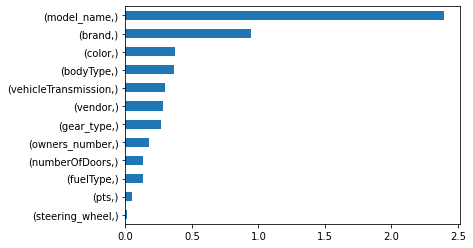

In [43]:
# посмотрим значимость признаков (категориальные + бинарные)

imp_cat = Series(mutual_info_classif(train_data[cat_cols + bin_cols], train_data['price'], 
                                     discrete_features=True), index=[cat_cols + bin_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Категориальные и бинарные признаки не являются по сути числовыми, поэтому корреляционная матрица может быть не совсем уместна. Однако все равно построим данную матрицу для получения максимума возможной информации.

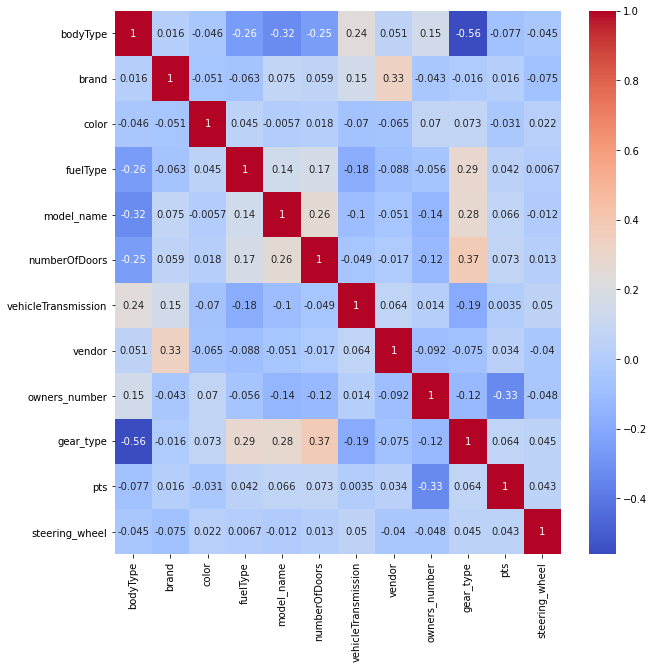

In [44]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_data[cat_cols + bin_cols].corr(), 
                 annot=True, cmap='coolwarm')

In [45]:
nom_cols = cat_cols + bin_cols

for col in nom_cols:
    get_stat_dif(col, train_data)

Найдены статистически значимые различия для колонки bodyType
Найдены статистически значимые различия для колонки brand
Найдены статистически значимые различия для колонки color
Найдены статистически значимые различия для колонки fuelType
Найдены статистически значимые различия для колонки model_name
Найдены статистически значимые различия для колонки numberOfDoors
Найдены статистически значимые различия для колонки vehicleTransmission
Найдены статистически значимые различия для колонки vendor
Найдены статистически значимые различия для колонки owners_number
Найдены статистически значимые различия для колонки gear_type
Найдены статистически значимые различия для колонки pts
Найдены статистически значимые различия для колонки steering_wheel


Мы видим, что модель автомобиля оказывает подавляющее влияние на стоимость автомобиля. Менее всего оригинальность ПТС и ориентация руля. Возможно, мы сможем создать дополнительные признаки на основании имеющихся, и попробуем помочь модели в прогнозировании, сделав акцент на признаки, больше всего влияющие на целевую переменную. Мы видим корреляцию между моделью автомобиля и кол-ом дверей / приводом. Привод также хорошо скоррелирован с типом кузов и кол-ом дверей соответственно. На основании указанных выше признаков можно будет попробовать собрать новый признак и посмотреть, как это скажется на качестве модели.

### num_cols

In [46]:
num_inspector = NumericInspector(data)

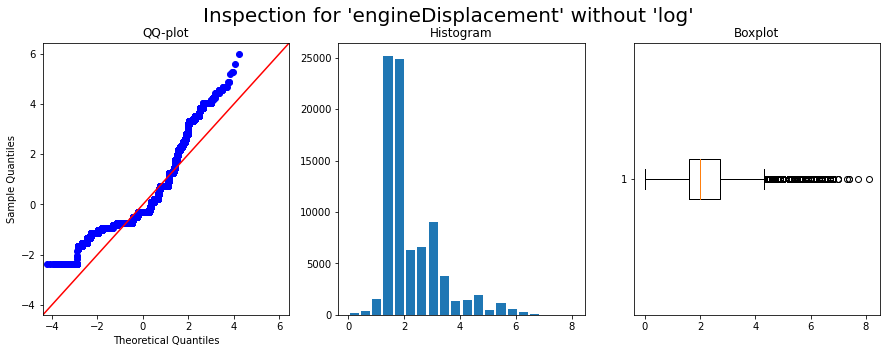

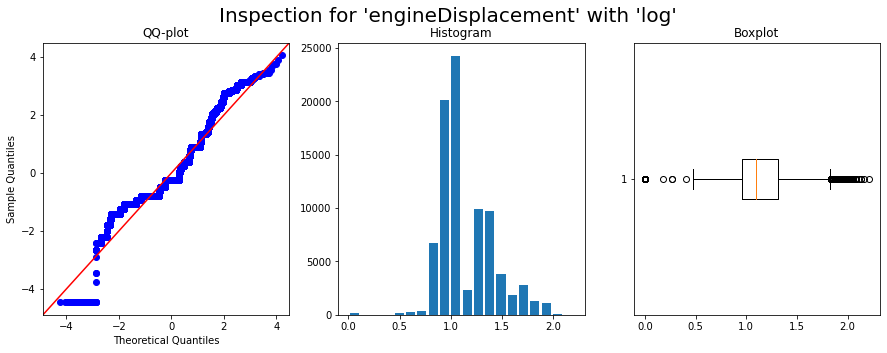

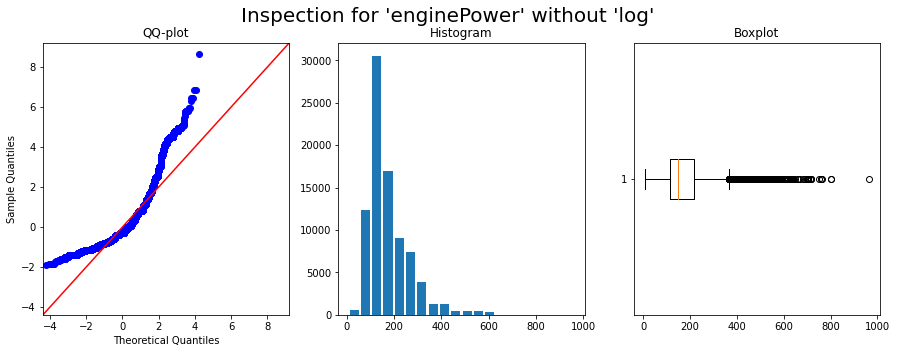

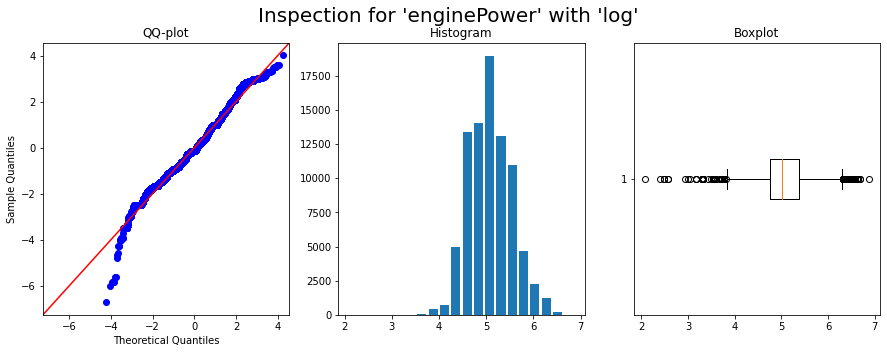

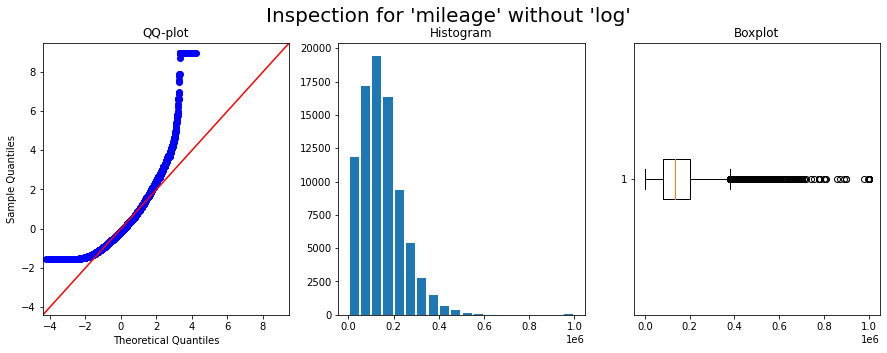

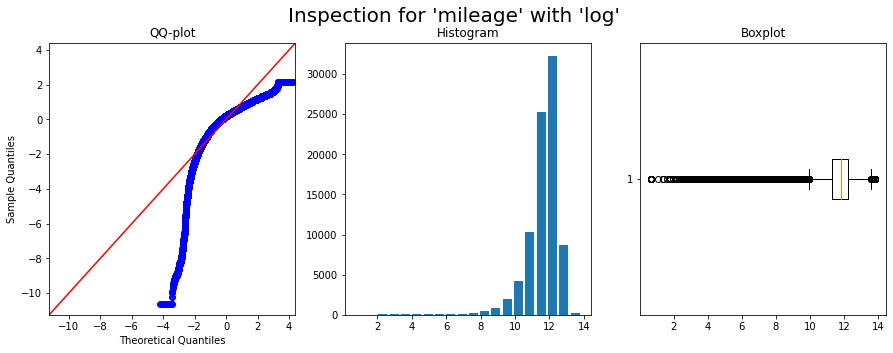

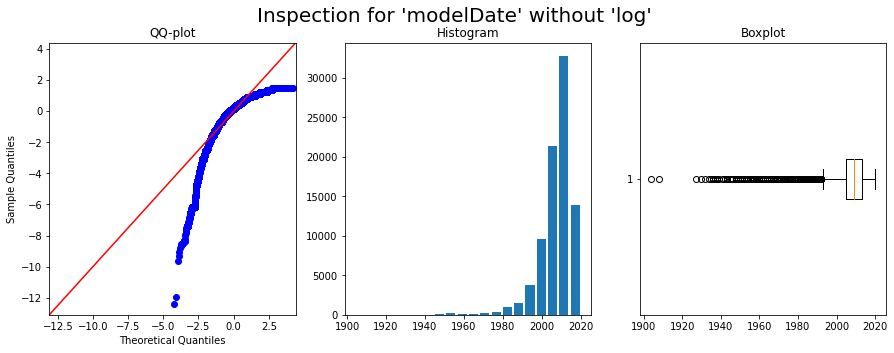

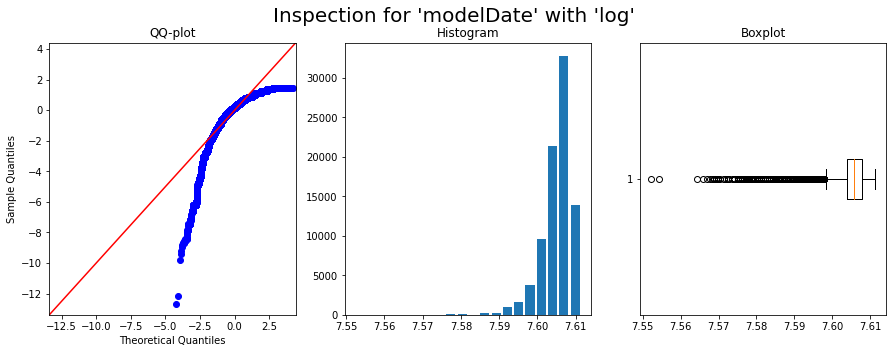

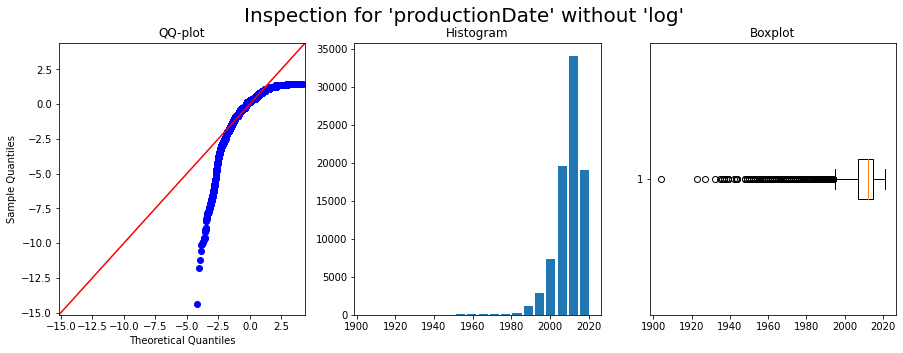

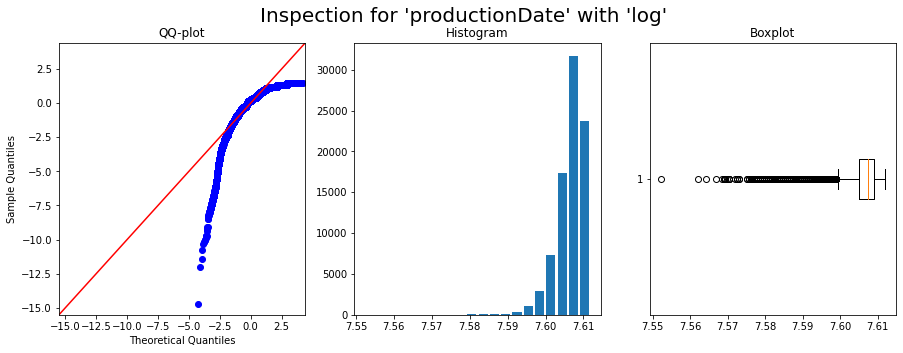

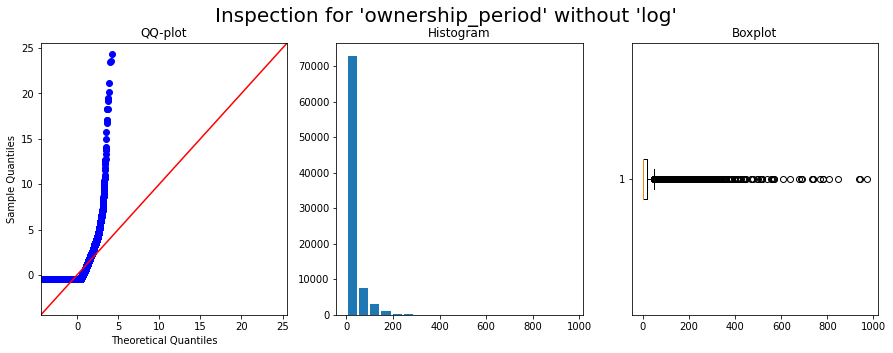

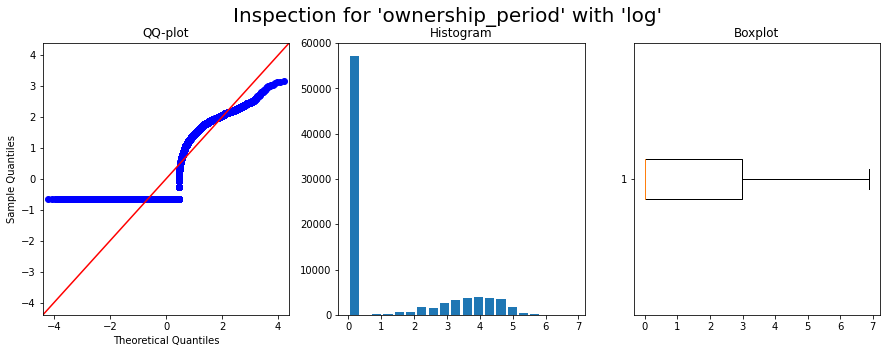

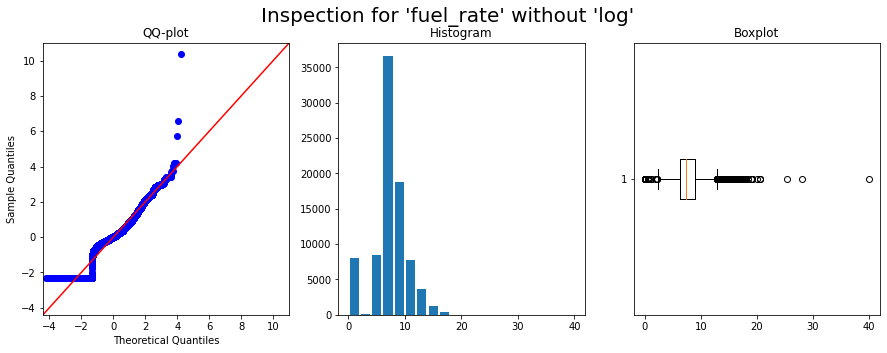

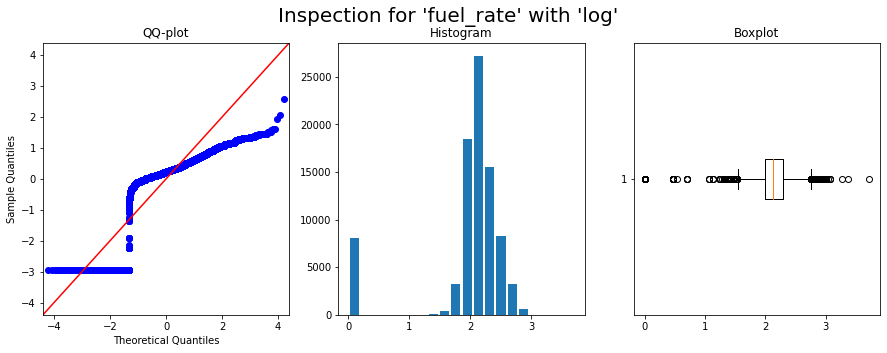

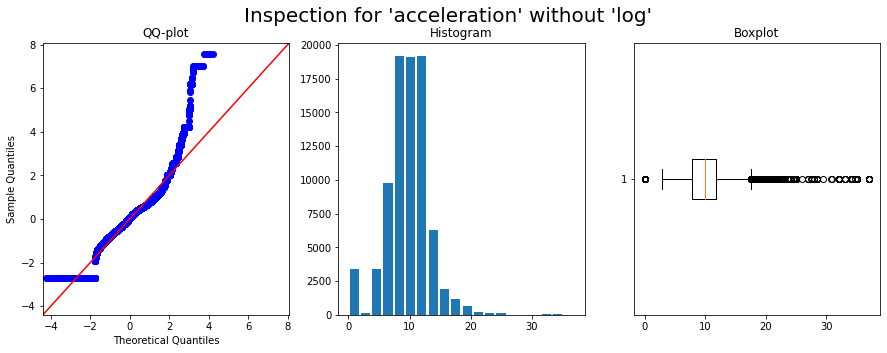

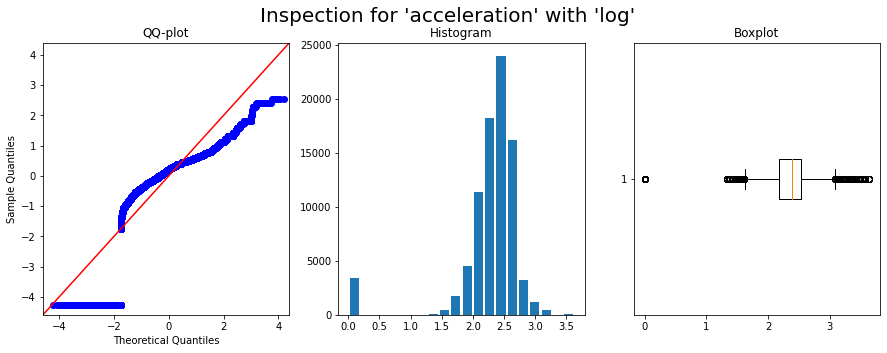

In [47]:
for col in num_cols:
    num_inspector.inspect(col)

#### ['engineDisplacement']

In [48]:
# посмотрим, сколько у нас нулевых значений

len(data[data['engineDisplacement'] == 0])

166

In [49]:
data['engineDisplacement'].describe()

count    84969.000000
mean         2.295335
std          0.965285
min          0.000000
25%          1.600000
50%          2.000000
75%          2.700000
max          8.100000
Name: engineDisplacement, dtype: float64

In [50]:
len(data.query('engineDisplacement >= 4.35'))

5195

Несмотря на то, что у нас более 5000 наблюдений относятся к выбросам, по факту однозначно считать их таковыми сложно. В выборке действительно есть автомобили с большим объемом двигателя и это может влиять на цену. Для нивелирования попробуем создать категориальный признак, а также создадим признак электрокара.

In [51]:
data['is_electro'] = data['engineDisplacement'].apply(lambda x: 1 if x == 0 else 0)

Создадим категориальный признак объема двигателя.

In [52]:
data['engineDisplacement_cat'] = data['engineDisplacement'].apply(lambda x: 1 if 0 <= x <=1.1 else 2 if 1.2 <= x <= 1.7
                                                                 else 3 if 1.8 <= x <= 3.5 else 4)

In [53]:
# работа с выбросами

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 4.35 if x >= 4.35 else x)

Логарифмируем данные.

In [54]:
data['engineDisplacement'] = np.log(data['engineDisplacement'] + 1)

Сделаем тоже самое еще с двуми признаками: мощность двигателя и пробег.

#### ['enginePower']

In [55]:
data['enginePower'].describe()

count    84969.000000
mean       177.937471
std         90.382270
min          7.000000
25%        115.000000
50%        150.000000
75%        215.000000
max        963.000000
Name: enginePower, dtype: float64

In [56]:
len(data.query('enginePower >= 365'))

4081

Здесь у нас также более 4000 наблюдений относятся к выбросам, по факту однозначно считать их таковыми сложно. В выборке действительно есть автомобили с мощным двигателя и это может влиять на цену. Для нивелирования попробуем создать категориальный признак.

In [57]:
data['enginePower_cat'] = data['enginePower'].apply(lambda x: 1 if 0 <= x <= 70 else 2 if 71 <= x <= 100 
                                                    else 3 if 101 <= x <= 150 else 4 if 151 <= x <= 200
                                                   else 5)

In [58]:
# работа с выбросами

data['enginePower'] = data['enginePower'].apply(lambda x: 365 if x >= 365 else x)

Логарифмируем данные.

In [59]:
data['enginePower'] = np.log(data['enginePower'] + 1)

#### ['mileage']

In [60]:
data['mileage'].describe()

count      84969.000000
mean      148414.669338
std        95161.748672
min            1.000000
25%        80000.000000
50%       136000.000000
75%       199388.000000
max      1000000.000000
Name: mileage, dtype: float64

In [61]:
len(data.query('mileage >= 378470'))

1944

В этом признаке мы также наблюдаем большое кол-во выбросов. Далее при построении модели при необходимости вернемся и проэкспериментируем со сглаживанием верхней границы выбросов в этом признаке, наряду с двумя предыдущими. На данным момент их не трогаем. Создадим дополнительный категориальный признак пробега, логарифмировать не будем.

In [62]:
data['mileage_cat'] = data['mileage'].apply(lambda x: 1 if 0 <= x <= 100000 else 2 if 100001 <= x <= 300000 else 3)

In [63]:
data['mileage'] = data['mileage'].apply(lambda x: 378470 if x >= 378470 else x)

#### ['modelDate'] / ['productionDate']

Эти два признака содержат выбросы, однако они имеют место быть. Логарифмирование не производим.

In [64]:
data['is_old_model'] = data['modelDate'].apply(lambda x: 1 if x <= 1993 else 0)

In [65]:
data['is_old_prod'] = data['productionDate'].apply(lambda x: 1 if x <= 1995 else 0)

#### ['ownership_period']

Признак времени владения. Более 60% имеют нулевые значения - это связано с пропусками в данных. Теоретически невозможно, чтобы автомобиль б/у находился до этого во владении 0 месяцев. Попробуем выделить нулевые значения в отдельный признак - period_unknown, а нулевые значения в исходном признаке заменить на медианные. Экспериментально оценим, как это окажет влияние на модель или нет. И если да - то в какую сторону. 

In [66]:
len(data.query('ownership_period == 0'))

57190

In [67]:
data['period_unknown'] = data.ownership_period.apply(lambda x: 1 if x == 0 else 0)

In [68]:
# преобразуем нули в пропуски, чтобы оценить распределение

data.ownership_period = data.ownership_period.apply(lambda x: None if x == 0 else x)

In [69]:
data.ownership_period.describe()

count    27779.000000
mean        55.333633
std         51.336454
min          1.000000
25%         20.000000
50%         41.000000
75%         78.000000
max        971.000000
Name: ownership_period, dtype: float64

Заменим пропуски на медианное значение.

In [70]:
data.ownership_period = data.ownership_period.fillna(41)

Логарифмируем данные.

In [71]:
data['ownership_period'] = np.log(data['ownership_period'] + 1)

#### ['fuel_rate'] / ['acceleration']

In [72]:
data.query('fuel_rate == 0').sample(10)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners_number,ownership_period,pts,gear_type,steering_wheel,sample,price,fuel_rate,acceleration,is_electro,engineDisplacement_cat,enginePower_cat,mileage_cat,is_old_model,is_old_prod,period_unknown
34846,11,9,11,None,"249лс. , 92 бензин , классика - атмосферник , ...",1.410987,5.521461,"{'cruise-control': True, 'tinted-glass': True,...",0,163600,2004,180,4,2007,1102846473,0,2,3,2.833213,1,2,1,1,865000.0,0.0,7.1,0,3,5,2,0,0,0
58705,11,79,13,None,NaN,1.252763,5.123964,"{'electro-window-back': True, 'cruise-control'...",0,316000,1993,1363,4,1999,1103319243,0,3,3,2.302585,1,1,1,1,220000.0,0.0,10.7,0,3,4,3,1,0,0
53108,11,66,2,None,Машина на уверенном ходу и не требует вложений...,0.955511,4.663439,{},0,200000,2003,342,4,2005,1103157935,0,4,3,3.737670,1,1,1,1,240000.0,0.0,11.8,0,2,3,2,0,0,1
6372,11,120,15,"{'id': '20893421', 'name': 'Inscription', 'ava...",Отличное состояние. Комплектация INSCRIPTION.\...,1.098612,5.521461,"{'esp': True, 'usb': True, 'multi-wheel': True...",0,46613,2016,1064,4,2017,1100684298,0,2,1,3.737670,1,1,1,0,NaN,0.0,6.8,0,3,5,1,0,0,1
78831,8,115,15,None,"В 2014 году заказывал с Японии, состояние внеш...",1.223775,5.141664,"{'engine-proof': True, 'tinted-glass': True, '...",0,163000,2008,1281,5,2011,1103315618,1,3,1,4.394449,1,2,0,1,1950000.0,0.0,0.0,0,3,4,2,0,0,0
6435,11,120,13,None,Безопасность: 3. Комфорт: 5. Защита от угона: ...,0.955511,4.615121,"{'airbag-passenger': True, 'electro-window-bac...",0,96820,2004,1055,4,2007,1101173645,2,2,1,3.737670,1,1,1,0,NaN,0.0,11.9,0,2,2,1,0,0,1
34491,11,87,15,None,"Незначительные повреждения кузова, в ДТП автом...",0.955511,4.709530,"{'tinted-glass': True, 'abs': True, 'lock': Tr...",0,200000,2004,1221,4,2008,1097135934,2,3,1,3.737670,1,1,1,0,NaN,0.0,10.5,0,2,3,2,0,0,1
69200,18,89,4,None,"4 колеса в подарок, возможен торг в хорошем со...",0.955511,4.330733,"{'tinted-glass': True, 'aux': True, 'usb': Tru...",0,231791,1998,223,5,1998,1103399047,2,2,3,2.079442,0,1,1,1,140000.0,0.0,14.5,0,2,2,2,0,0,0
16560,8,80,1,None,Год выпуска: 2003. Пробег: 480 000 км. Кузов: ...,1.163151,4.418841,None,3,378470,1996,1304,4,2003,1101207040,2,2,3,3.737670,1,1,1,0,NaN,0.0,22.0,0,3,2,3,0,0,1
61357,0,80,12,None,"второй владелец по птс, птс оригинал, езжу как...",1.386294,5.484797,"{'asr': True, 'tinted-glass': True, 'esp': Tru...",3,185000,2011,872,5,2011,1064021360,0,2,2,4.262680,1,2,1,1,1730000.0,0.0,8.8,0,3,5,2,0,0,0


Судя по данным, нулевое значение расхода на связано с принадлежностью к эектрокарам. В таком случае - это пропуски. Попробуем их заполнить медианой.

In [73]:
data.fuel_rate.describe()

count    84969.000000
mean         7.326574
std          3.151901
min          0.000000
25%          6.300000
50%          7.400000
75%          8.900000
max         40.000000
Name: fuel_rate, dtype: float64

In [74]:
data.acceleration.describe()

count    84969.000000
mean         9.762716
std          3.603004
min          0.000000
25%          7.800000
50%          9.900000
75%         11.700000
max         37.000000
Name: acceleration, dtype: float64

In [75]:
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 7.4 if x == 0 else x)

In [76]:
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 3.4 if x <= 3.4 else x)
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 12.8 if x >= 12.8 else x)

In [77]:
data['fuel_rate'] = np.log(data['fuel_rate'] + 1)

In [78]:
data['acceleration'] = data['acceleration'].apply(lambda x: 9.9 if x == 0 else x)

In [79]:
data['acceleration'] = data['acceleration'].apply(lambda x: 2.7 if x <= 2.7 else x)
data['acceleration'] = data['acceleration'].apply(lambda x: 17.1 if x >= 17.1 else x)

In [80]:
# выделим часть train и посмотрим значимость признаков

train_data = data.query('sample == 1').drop(['sample'], axis=1)

In [81]:
cat_cols.extend(['engineDisplacement_cat', 'enginePower_cat', 'mileage_cat'])
bin_cols.extend(['is_electro', 'period_unknown'])

<AxesSubplot:>

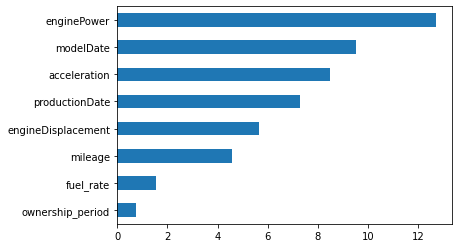

In [82]:
# посмотрим значимость признаков

imp_num = Series(f_classif(train_data[num_cols], train_data['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

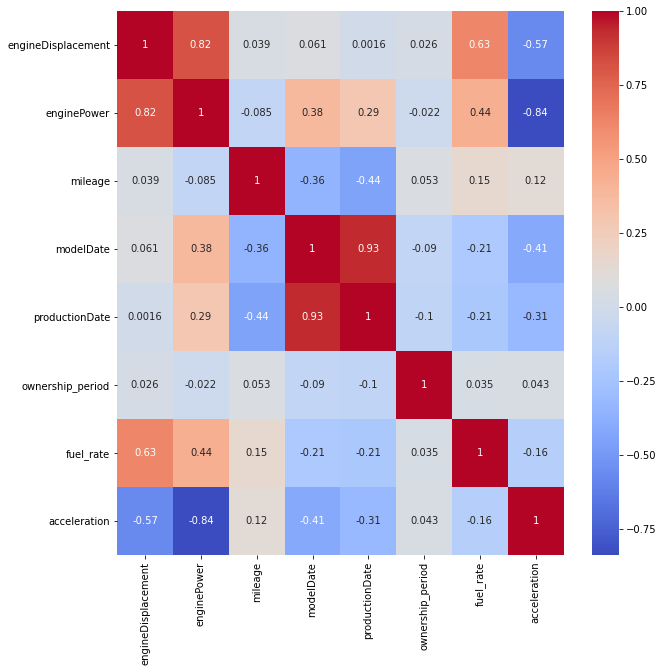

In [83]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_data[num_cols].corr(), 
                 annot=True, cmap='coolwarm')

<AxesSubplot:>

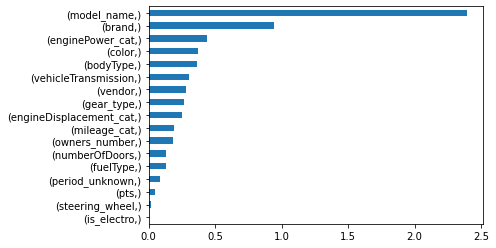

In [84]:
# посмотрим значимость признаков 

imp_cat = Series(mutual_info_classif(train_data[cat_cols + bin_cols], train_data['price'], 
                                     discrete_features=True), index=[cat_cols + bin_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

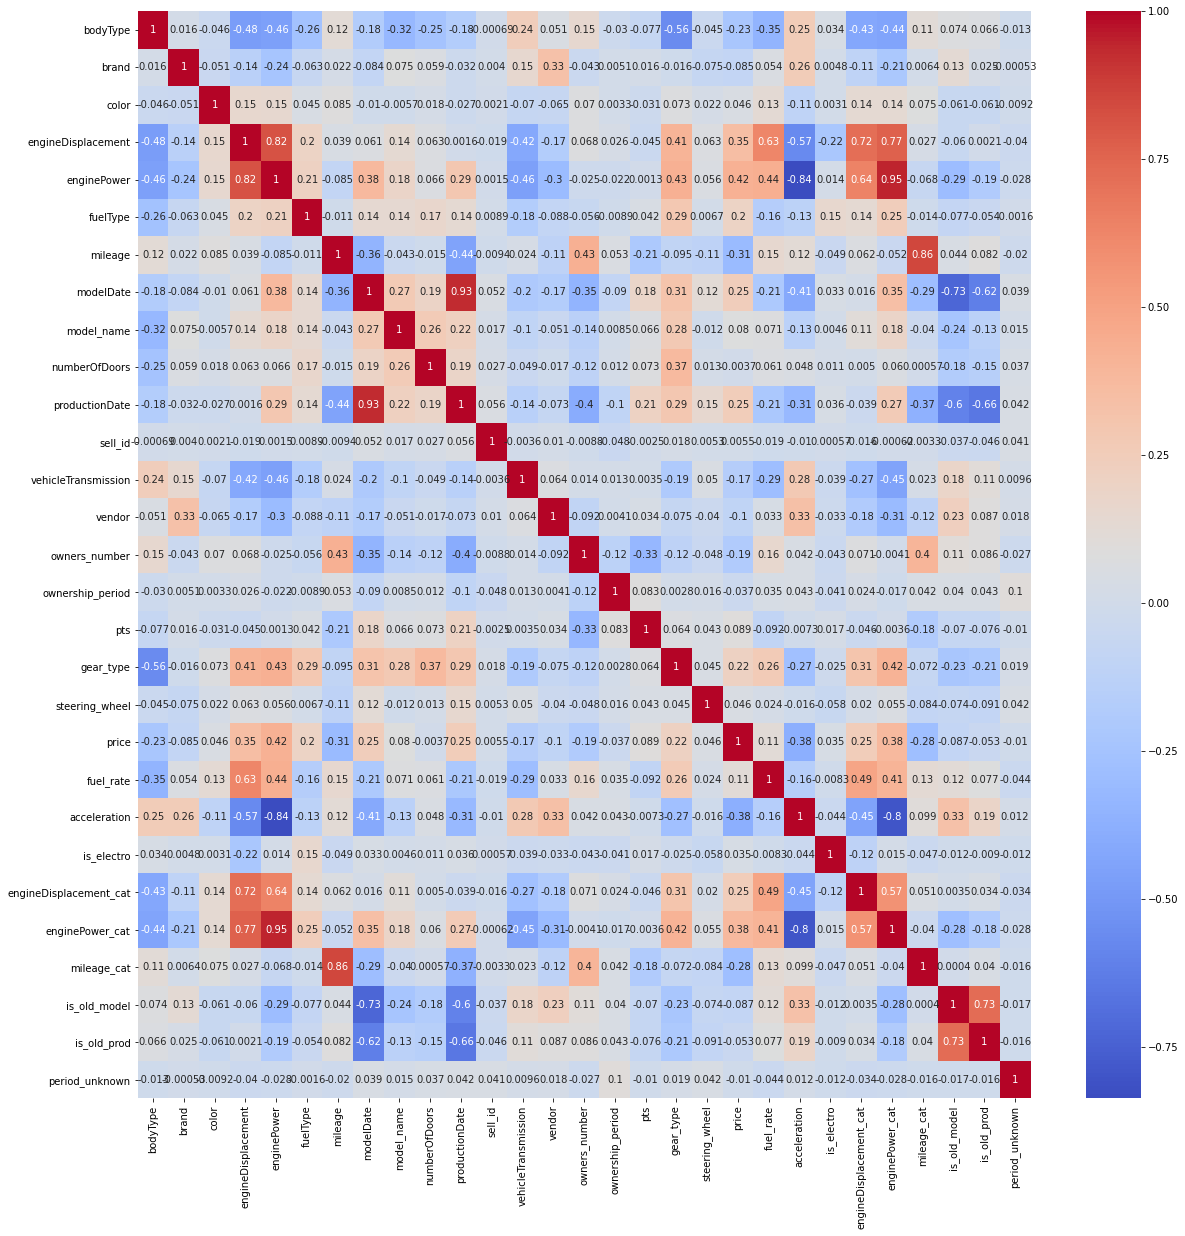

In [85]:
# Посмотрим общую корреляцию
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(train_data.corr(), 
                 annot=True, cmap='coolwarm')

# Выводы

- Представленные выше графики построены для разведывательного анализа данных. Мы видим, что на цену автомобиля больше всего влияют следующие признаки: объем двигателя, его мощность, пробег, разгон, год производства. Название модели и тип топлива также важны для цены. Между model_date и production_date существует сильная корреляция - один из признаков, вероятно, будет убран.
- Чтобы отслеживать, насколько то или иное дальнейшее изменение полезно для модели, построим изначально наивную модель и посмотрим метрику mape.
- На основании проведенного выше анализа данных, предлагается далее провести эксперименты с данными (отбор признаков, эксперименты со сглаживанием выбросов, добавление новых на основании имеющихся), опираясь на изменения в метриках модели.
- Далее необходимо построить модели с учетом подбора гиперпараметров, отбором признаков и стекингом.
- При построении модели, вероятно, будет необходимо делать логарифмирование целевой переменной.

# Naive model

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [86]:
train_data = data.query('sample == 1').drop(['sample', 'complectation_dict', 'description', 'equipment_dict'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [88]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [89]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 98.27%


# Model experiments

In [90]:
# train_data = data.query('sample == 1').drop(['sample', 'complectation_dict', 'description', 'equipment_dict', 'productionDate'], axis=1)
# X = train_data.drop(['price'], axis=1)
# y = train_data['price']

In [91]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [92]:
# scaler = StandardScaler()
# X_train_st = scaler.fit_transform(X_train)
# X_test_st = scaler.transform(X_test)

In [93]:
# # LinearRegression

# lr = LinearRegression().fit(X_train_st, np.log(y_train))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(lr.predict(X_test_st))))*100:0.2f}%")

In [94]:
# # RandomForestRegressor

# rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train_st, np.log(y_train))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test_st))))*100:0.2f}%")

In [95]:
# # ExtraTreesRegressor

# et = ExtraTreesRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train_st, np.log(y_train))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(et.predict(X_test_st))))*100:0.2f}%")

In [96]:
# # DecisionTreeRegressor

# dt = DecisionTreeRegressor(random_state = RANDOM_SEED).fit(X_train_st, np.log(y_train))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(dt.predict(X_test_st))))*100:0.2f}%")

In [97]:
# # Kneigbors

# kn = KNeighborsRegressor(n_jobs=-1).fit(X_train_st, np.log(y_train))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(dt.predict(X_test_st))))*100:0.2f}%")

In [98]:
# # AdaBoost

# adb = AdaBoostRegressor(random_state = RANDOM_SEED).fit(X_train_st, np.log(y_train))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(adb.predict(X_test_st))))*100:0.2f}%")

In [99]:
# # GradientBoosting

# gb = GradientBoostingRegressor(random_state = RANDOM_SEED).fit(X_train_st, np.log(y_train))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test_st))))*100:0.2f}%")

In [100]:
# # XGboost

# xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
#                       max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
# xb.fit(X_train_st, np.log(y_train))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test_st))))*100:0.2f}%")

In [101]:
# # CatBoost

# model = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train_st, np.log(y_train),
#          eval_set=(X_test_st, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True
#          )

# model.save_model('catboost_single_model_2_baseline.model')

# predict_test = np.exp(model.predict(X_test_st))

# print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

# Stacking

In [102]:
train_data = data.query('sample == 1').drop(['sample', 'complectation_dict', 'description', 
                                             'equipment_dict', 'productionDate', 'is_old_model',
                                            'engineDisplacement_cat', 'vehicleTransmission'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [103]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [118]:
estimators = [
    ('rf', RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbose=1,
        n_estimators=1800,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        max_depth=60,
        bootstrap=True
    )),
    ('ext', ExtraTreesRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbose=1,
        bootstrap=True,
        max_depth=57,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=2300
    )),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                             learning_rate=0.03,
                             max_depth=12, alpha=1,
                             n_jobs=-1, n_estimators=1000))]

reg = StackingRegressor(estimators=estimators, cv=cv, final_estimator=CatBoostRegressor(iterations=5000,
                                                                                        random_seed=RANDOM_SEED,
                                                                                        eval_metric='MAPE',
                                                                                        custom_metric=[
                                                                                            'R2', 'MAE'],
                                                                                        silent=True))
reg.fit(X_train_st, np.log(y_train))
y_pred = np.exp(reg.predict(X_test_st))

print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1512 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   25.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 1785 out of 1800 | elapsed:   21.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:   21.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks     

Точность модели по метрике MAPE: 16.17%


In [ ]:
# https://catboost.ai/docs/features/training-on-gpu.html

parameters = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [int(x) for x in np.linspace(start=100, stop=5000, num=10)]
}

grid = GridSearchCV(
    estimator=CatBoostRegressor(
        random_seed=RANDOM_SEED,
        eval_metric='MAPE',
        custom_metric=['R2', 'MAE'],
        silent=True
    ),
    verbose=10,
    param_grid=parameters,
    n_jobs=-1
)

grid.fit(X_train_st, np.log(y_train))
grid.grid_scores_, grid.best_params_, grid.best_score_

In [ ]:
parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'objective': ['reg:squarederror']
    'n_estimators': [int(x) for x in np.linspace(start=1000, stop=2000, num=5)]
}

grid2 = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(colsample_bytree=0.5, alpha=1),
    param_grid=parameters,
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=10
)

grid2.fit(X_train_st, np.log(y_train))
grid2.grid_scores_, grid2.best_params_, grid2.best_score_

In [ ]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(
            dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'], eval_metric='auc')

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    # Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)

    feat_imp = pd.Series(alg.booster().get_fscore()
                         ).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
# Choose all predictors except target
predictors = [x for x in X_train_st.columns if x not in [target, IDcol]]

xgb1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,
    learning_rate=0.03,
    max_depth=12, alpha=1,
    n_jobs=-1, n_estimators=1000)

modelfit(xgb1, train, predictors)

# Идеи

1. Надо попробовать избавиться от выбросов.
2. Надо провести отбор признаков.
3. Попробовать добавить полиномиальные признаки.
4. У целевой переменной перед логарифмированием делить ее на 1.08 (изменения в цене - коэффициент), затем уже логарифм.
5. Дальше надо, конечно, играться со стекингом. Пробовать разные модели между собой, разные мета-модели, подбирать фолды и, конечно, разные параметры. Может, у тебя получится написать код, чтобы он проверил все варианты estimators и подобрал лучшие? как с гиперпараметрами мы подбирали.

Пока как-то так.

Для сабмита

In [105]:
X_sub = data.query('sample == 0').drop(['sample', 'complectation_dict', 'description', 
                                             'equipment_dict', 'productionDate', 'is_old_model',
                                            'engineDisplacement_cat', 'vehicleTransmission', 'price'], axis=1)

In [106]:
X_sub = scaler.transform(X_sub)

In [107]:
predict_submission = np.exp(reg.predict(X_sub))*0.92

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [108]:
sample_submission = pd.read_csv('sample_submission.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'sample_submission.csv'

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)